# **Numerical model LisFlood FP**

<span style="font-family: times, Optima; font-size:11pt; color:black;">
LISFLOOD-FP is a hydrodinamic numerical model designed to simulate floodplain inundation events.
<span

In [1]:
from IPython.display import IFrame, Video
IFrame("../../lib/resources/LisfloodFP.pdf", width=800, height=500)

In [6]:
Video("../../lib/resources/Guam_flood_acc.mp4", width=800, height=500)

In [7]:
Video("../../lib/resources/video_lisflood.mp4", width=800, height=500)

In [1]:
# pip
import os
import os.path as op
import sys

import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cmocean 

# dev
sys.path.insert(0, op.join(os.getcwd(), '..', '..'))

# LISFLOOD module 
from lib.lisfloodpy.wrap import LisfloodCase, LisfloodProject, LisfloodWrap 
from lib.lisfloodpy.plots import plot_output_2d
from lib.lisfloodpy.io import make_dem

from lib.config import *


<span style="font-family: times, Optima; font-size:11pt; color:black;">
<div class="alert alert-block alert-danger"><b>MHHW </b> Mean Highest High Water <br> The average of the higher high water height of each tidal day over a total epoch (19 years). <br> The "zs" water depths defined as input coditions for LisFlood-FP must be given over this threshold.</div><span

## Load input DEM

In [2]:
# data folder
p_data = op.abspath(op.join(os.getcwd(), '..', 'data', 'lisflood'))

# projects path
p_proj = op.join(p_data, 'projects')

In [3]:
# Setup files 
p_dem = op.join(p_data, 'config', 'DEM.asc')
p_bci = op.join(p_data, 'config', 'boundary.bci')

## Load forcing input 

In [4]:
MHHW = 0.7
sim_period = 3600  # seconds
zs = [1, 2, 3]               # water level above 0.7 (MHHW)

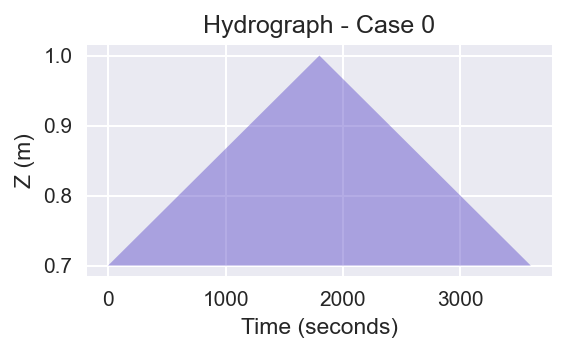

In [5]:
# prepare and store Lisflood cases inside a list
l_cases = []
for pz, z in enumerate(zs):
    time = np.arange(sim_period)
    z = np.concatenate([np.linspace(MHHW, z, int(sim_period/2)), np.linspace(z, MHHW, sim_period- int(sim_period/2))]) 
    
    xds = xr.Dataset(
        {'z': (('time',), z)},
        coords = {'time': time},
        attrs = {'units': 'm'},
    )
    
    plt.figure(figsize=(4,2))
    plt.fill_between(xds.time.values, np.ones(len(xds.z.values))*MHHW, xds.z.values, fc='slateblue', alpha=0.5)
    plt.title('Hydrograph - Case {0}'.format(pz))
    plt.xlabel('Time (seconds)')
    plt.ylabel('Z (m)')
    
    lc = LisfloodCase()
    lc.id = 'case{0}'.format(pz)

    # set levels
    lc.hvar_activate = True
    lc.level_value = xds['z']
    lc.level_freq = 'seconds' 
    
    l_cases.append(lc)

## Create cases project 

In [6]:
# Lisflood PROJECT 

p_proj = op.join(p_data, 'projects')  # lisflood projects main directory
n_proj = ''                           # project name

lp = LisfloodProject(p_proj, n_proj)  # lisflood wrap

# DEM 
lp.dem_file = p_dem
lp.bci_file = p_bci
lp.cartesian = True

lp.ncols = 3300
lp.nrows = 1660
lp.xllcorner = 408002.50
lp.yllcorner = 8467002.50
lp.cellsize = 5
lp.nodata = -9999  

# LISFLOOD parameters
lp.saveint = 120           # interval saved files (s)
lp.massint = 120           # interval .mass file (s)
lp.sim_time = 3600        # simulation length (s)
lp.initial_tstep = 10      # Initial guess for optimum and max time step
lp.fpfric = 0.06            # Manning's (floodplain) if spatially uniform

# Water balance parameters
lp.routing = False           # recommended for rainfall when steep sloopes
lp.depththresh = 0.005      # depth at which a cell is considered wet (m)
#lp.routesfthresh = 0.1      # Water surface slope above which routing occurs

# Output options
lp.overpass = None          # time in seconds at which save flood image for validation
lp.depthoff = True          # suppress depth files (*.wd) 
lp.elevoff = True           # suppress water surface files (*.elev)

# Model solver
lp.solver = 'Roe'


## Launch wrapper 

In [7]:
# Lisflood WRAP 
lw = LisfloodWrap(lp)

In [7]:
# Build cases: rainfall flooding with and without coastal "outflow" 
lw.build_cases(l_cases)

# Run LISFLOOD-FP
lw.run_cases()

Case case0 built.
Case case1 built.
Case case2 built.

 Running LISFLOOD-FP case...


 Running LISFLOOD-FP case...


 Running LISFLOOD-FP case...



## Postprocess output

### Load output files

In [8]:
# Lisflood OUTPUT
# .inittm .maxtm .totaltm .max .mxe
xds_res = lw.extract_output('2d')
xds_res

<xarray.Dataset>
Dimensions:  (case: 1, y: 1660, x: 3300)
Coordinates:
  * x        (x) float64 4.08e+05 4.08e+05 4.08e+05 ... 4.245e+05 4.245e+05
  * y        (y) float64 8.467e+06 8.467e+06 8.467e+06 ... 8.475e+06 8.475e+06
Dimensions without coordinates: case
Data variables:
    inittm   (case, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    maxtm    (case, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    totaltm  (case, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    max      (case, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mxe      (case, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
Attributes:
    nondata:     None
    simtime(h):  1.0
    xlabel:      X_utm (m)
    ylabel:      Y_utm (m)

### Plot output maps

In [9]:
# Plot 2D output
sim_time = int(xds_res.attrs['simtime(h)'])
cmap = cmocean.cm.dense
name = 'Apia Coastal Flooding'
var_plot = 'max'

In [10]:
# plot 2d output map
vmax = 6
plot_output_2d(name, xds_res, var_plot, sim_time, vmax, cmap)

### Convert rasters to text file 

In [11]:
for case in xds_res.case.values:
    
    p_storage = op.join(p_data, 'projects', 'case{0}'.format(case))
    
    # store datase into .tif
    xds_res.sel(case=case).rio.write_crs('epsg:{0}'.format(code_crs_samoa)).rio.to_raster(op.join(p_storage, 'flooding_raster.tif'))
    
    # create and store .asc file
    make_dem(xds_res.isel(case=case-1), op.join(p_storage, 'flooding_raster.asc'))
